In [1]:
# !pip install scikit-plot

# Import Necessary Libraries


In [1]:
# necessary packages for training deep learning algorithms 
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
import scikitplot as skplt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import io
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Reading the Dataset and analysis

In [2]:
train_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Training\\'

test_dir = 'F:\\Ml files\\brain tumor classification\\Data\\Testing\\'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

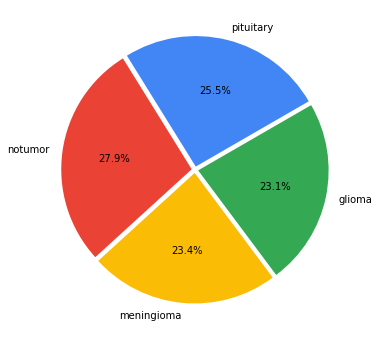

In [3]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']

plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

# Defining Labels and loading dataset


In [4]:
X_train = [] #Training image
Y_train = [] #Training Labels

# define the labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# resize the images
image_size=150

# load the training data into X_train and y_train
for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
#         read the images into an array
        image = cv2.imread(os.path.join(folderPath, j))
#     resize the image into (150,150)
        image = cv2.resize(image, (image_size, image_size))
#     added the image into X_train
        X_train.append(image)
    #     added the label into Y_train
        Y_train.append(i)
        

# load the training data into X_train and y_train
for i in labels:
    folderPath = os.path.join('F:\\Ml files\\brain tumor classification\\Data\\', 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into numpy array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 210.19it/s]


In [5]:
X_train.shape #No of sample = 7023

(7023, 150, 150, 3)

In [6]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

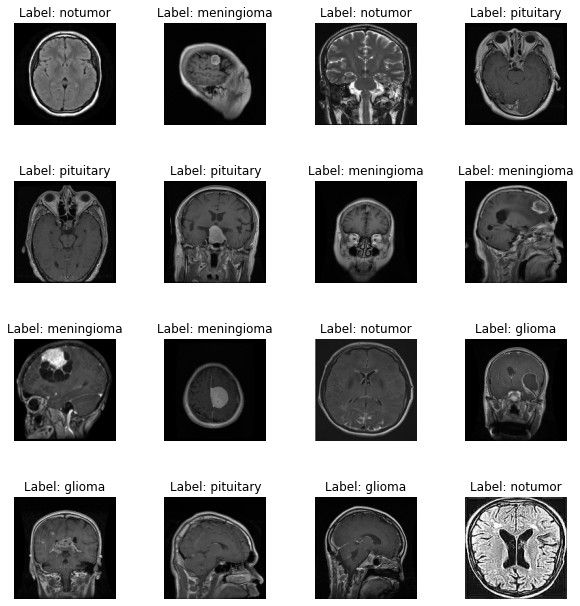

In [7]:
grid_width = 4
grid_height = 4
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

# Splitting data into : Train, Test, Valid as 70, 20, 10 ratio


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) # training 80% and testing 20%
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42) # training 70% testing 20% valid 10%

# Converting String Label to categorical


In [21]:
y_train_new = []
y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))
                                       
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

# Simple CNN Model


In [11]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [12]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

# Scaling Features : Train, Valid and Test

In [13]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

# Training the model

In [14]:
history = model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=64,
                   epochs=50,
                   verbose=1)

Epoch 1/50
79/79 [==============================] - 13s 91ms/step - loss: 1.2718 - accuracy: 0.5176 - val_loss: 0.5567 - val_accuracy: 0.7740
Epoch 2/50
79/79 [==============================] - 6s 72ms/step - loss: 0.4927 - accuracy: 0.8183 - val_loss: 0.3238 - val_accuracy: 0.8826
Epoch 3/50
79/79 [==============================] - 6s 71ms/step - loss: 0.2640 - accuracy: 0.9001 - val_loss: 0.2800 - val_accuracy: 0.9128
Epoch 4/50
79/79 [==============================] - 6s 72ms/step - loss: 0.1463 - accuracy: 0.9500 - val_loss: 0.2856 - val_accuracy: 0.8950
Epoch 5/50
79/79 [==============================] - 6s 71ms/step - loss: 0.1273 - accuracy: 0.9565 - val_loss: 0.2447 - val_accuracy: 0.9324
Epoch 6/50
79/79 [==============================] - 6s 73ms/step - loss: 0.0535 - accuracy: 0.9849 - val_loss: 0.2018 - val_accuracy: 0.9413
Epoch 7/50
79/79 [==============================] - 6s 72ms/step - loss: 0.0296 - accuracy: 0.9909 - val_loss: 0.2547 - val_accuracy: 0.9413
Epoch 8/50
7

# Accuracy and Loss Visualization

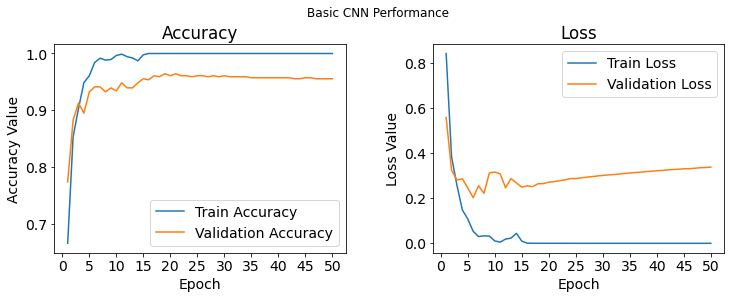

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,51))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 51, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


# Getting model predictions : Classification Report

In [17]:
# Getting model predictions
test_predictions = model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       310
           1       0.94      0.91      0.93       326
           2       0.97      0.97      0.97       419
           3       0.97      0.99      0.98       350

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



# Showing Confusion Matrix

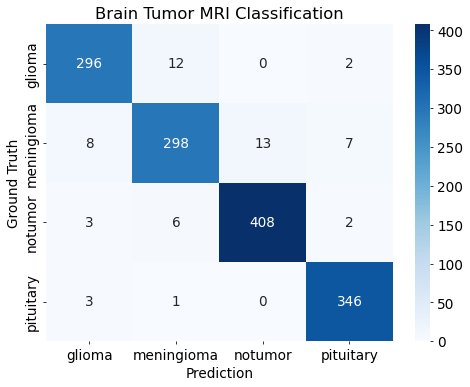

In [18]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

# Visualizing Model Predictions with Confidence

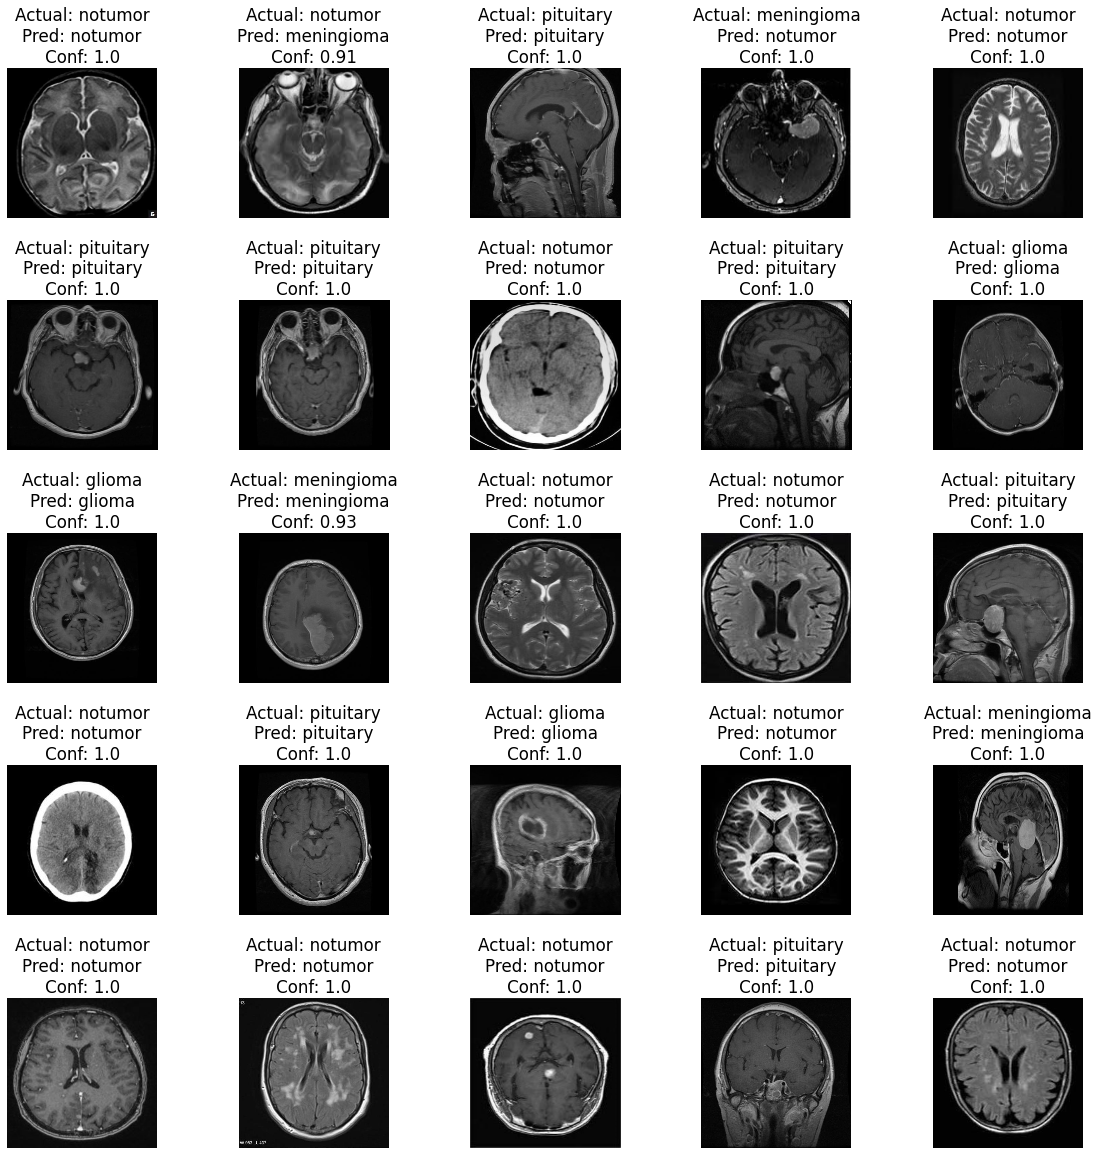

In [19]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(15, 15)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = actual_label[img_idx]
        predicted = preds[img_idx]
        confidence = round(test_predictions[img_idx][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)  